In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import pickle
import seaborn as sns
import sys
sys.setrecursionlimit(1500)
%matplotlib inline

In [2]:
def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

In [3]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('../data/enron//spam',        SPAM),
    ('../data/enron//easy_ham',    HAM)
   
]

SKIP_FILES = {'cmds'}
NEWLINE="\n"

def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path)
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'label': classification,'file':file_name})
        index.append(file_name)
   
    data_frame = pd.DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = pd.DataFrame({'text': [], 'label': [],'file':[]})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(np.random.permutation(data.index))
    return data

In [4]:
# We will load the Email spam dataset into Panadas dataframe here . 
data=load_data()

Percent: [##################################################] 100%

In [12]:
new_index=[x for x in range(len(data))]
data.index=new_index

In [13]:
def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['text']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized

In [14]:
data['tokenized_text']=data.apply(tokenize, axis=1)

In [15]:
data['token_count']=data.apply(token_count, axis=1)

In [16]:
data['lang']='en'

In [17]:
data.head()

,file,label,text,tokenized_text,token_count,lang
0,../data/enron//kitchen-l/_americas_netco_canada/4,ham,The name for the Canadian entity which will en...,The name for the Canadian entity which will en...,41,en
1,../data/enron//SH/HP/prodmsg.2.443312.2005712,spam,This is a multi-part message in MIME format.\n...,This is a multi-part message in MIME format.--...,234,en
2,../data/enron//williams-w3/bill_williams_iii/162,ham,Paul Choi\n,Paul Choi,2,en
3,../data/enron//easy_ham/1380.c3103ee67e5faa844...,ham,This mixer is specific to ALSA's special stuff...,This mixer is specific to ALSA's special stuff...,217,en
4,../data/enron//SH/HP/prodmsg.2.445867.2005716,spam,----5497156991003730\n\nContent-Type: text/htm...,----5497156991003730Content-Type: text/html;Co...,528,en


In [18]:
df=data
print("total emails : ", len(df))
print  ("total spam emails : ", len(df[df['label']=='spam']) )
print  ("total normal emails : ", len(df[df['label']=='ham']) )

('total emails : ', 58910)
('total spam emails : ', 35371)
('total normal emails : ', 23539)


Text(0.5,1,u'Plot of Emails count with languages and email type')

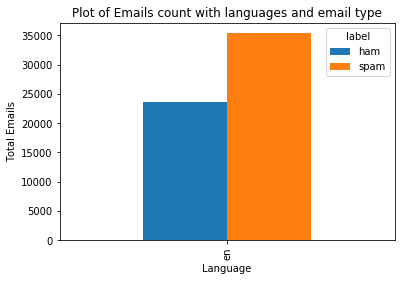

In [12]:
df1 = df.groupby(['lang','label'])['label','lang'].size().unstack()

ax=df1.plot(kind='bar')
ax.set_ylabel("Total Emails")
ax.set_xlabel("Language")
ax.set_title("Plot of Emails count with languages and email type")

Text(0.5,1,u'Token length Vs Frequency for Enron Spam Emails')

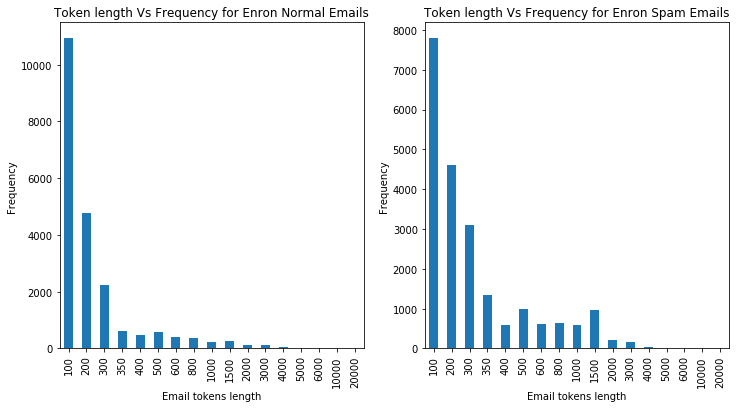

In [13]:
bins = [0,100,200,300,350,400,500,600,800,1000,1500,2000,3000,4000,5000,6000,10000,20000]


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
fig.subplots_adjust(hspace=.5)

df_sub=df[ (df['lang']=='en') & (df['label']=='ham')]
df1 = df_sub.groupby(pd.cut(df_sub['token_count'], bins=bins)).token_count.count()
df1.index=[a.right for a in df1.index]
res1=df1.plot(kind='bar',ax=axes[0])
res1.set_xlabel('Email tokens length')
res1.set_ylabel('Frequency')
res1.set_title('Token length Vs Frequency for Enron Normal Emails')


df_sub=df[ (df['lang']=='en') & (df['label']=='spam')]
df1 = df_sub.groupby(pd.cut(df_sub['token_count'], bins=bins)).token_count.count()
df1.index=[a.right for a in df1.index]
res2=df1.plot(kind='bar',ax=axes[1])
res2.set_xlabel('Email tokens length')
res2.set_ylabel('Frequency')
res2.set_title('Token length Vs Frequency for Enron Spam Emails')

In [14]:
# We randomize the rows to subset the dataframe
df.reset_index(inplace=True)
df=df.reindex(np.random.permutation(df.index))

In [15]:
len(df)

58910

In [16]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [17]:
import sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

In [18]:
# max number of features
num_max = 4000

In [19]:
def train_tf_idf_model(texts):
    "train tf idf model "
    #tic = time.process_time()
    

    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    #toc = time.process_time()

    #print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok


def prepare_model_input(dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    #tic = time.process_time()
    
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    
    targets=list(dataframe['label'])
    targets = [1. if x=='spam' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    #toc = time.process_time()
    
    print('shape of labels: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    #print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    return sample_texts,sample_target

In [20]:
texts=list(df['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

In [21]:
# prepare model input data
mat_texts,tags=prepare_model_input(df,mode='tfidf')

('shape of labels: ', (58910,))
('shape of data: ', (58910, 4000))


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.30)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

('train data shape: ', (41237, 4000), (41237,))
('validation data shape :', (17673, 4000), (17673,))


In [61]:
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

kmodel = Sequential()
kmodel.add(Dense(512, activation='relu', input_shape=(num_max,)))
kmodel.add(Dropout(0.1))
kmodel.add(Dense(256, activation='relu'))
kmodel.add(Dropout(0.1))
kmodel.add(Dense(1, activation='sigmoid'))
kmodel.summary()
kmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


#checkpointer = callbacks.ModelCheckpoint(filepath="logs1/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='acc')
#csv_logger = CSVLogger('logs1/training_set_iranalysis.csv',separator=',', append=False)
#kmodel.fit(X_val, y_val, batch_size=32, nb_epoch=1000, validation_data=(X_val, y_val),callbacks=[checkpointer,csv_logger])
#model.save("logs1/lstm1layer_model.hdf5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               2048512   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 2,180,097
Trainable params: 2,180,097
Non-trainable params: 0
_________________________________________________________________


In [77]:
# get the compiled model
model = get_simple_model()

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2048512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,180,097
Trainable params: 2,180,097
Non-trainable params: 0
_________________________________________________________________
compile done
Train on 35704 samples, validate on 13206 samples
Epoch 1/10
35704/35704 [==============================] - 26s 730us/s

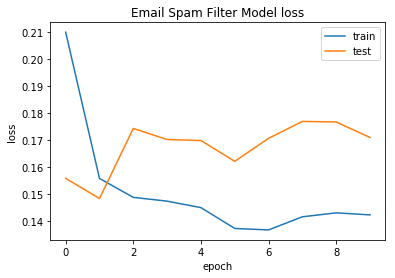

In [78]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [79]:
spam_model_svm = svm.SVC(verbose=1)
spam_model_svm.fit(X_train,y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=1)

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
spam_model_rf = RandomForestClassifier(n_jobs=2, random_state=0,n_estimators=50)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
spam_model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [82]:
# Build xgboost also 
import xgboost as xgb

/home/master/rbg/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [83]:
spam_model_xgboost = xgb.XGBClassifier()
spam_model_xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [97]:
sample_texts,sample_target=prepare_model_input(tfidf_model,df_unseen_test, mode='tf-idf1')

TypeError: prepare_model_input() got multiple values for keyword argument 'mode'

In [77]:
sample_texts = X_val 
sample_target = y_val

In [78]:
spam_model_dl = kmodel

In [79]:
model_dict={}
model_dict['random_forest']=spam_model_rf
model_dict['svm']=spam_model_svm
model_dict['deep_learning']=spam_model_dl
model_dict['xgboost']=spam_model_xgboost


def getResults(model_dict,sample_texts,sample_target):
    '''
    Get results from different models
    '''
    results=[]
    
    results_cm={}
    
    for name,model in model_dict.items():
#         print(name)
        #tic1 = time.process_time()
        if name in 'deep_learning':
            predicted_sample = predict(sample_texts)
        else:    
            predicted_sample = model.predict(sample_texts)
        #toc1 = time.process_time()
#         print(predicted_sample)

        cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample)
        results_cm[name]=cm
        
        total=len(predicted_sample)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        
        
        res=sklearn.metrics.precision_recall_fscore_support(sample_target, predicted_sample)
        results.append([name,np.mean(res[0]),np.mean(res[1]),np.mean(res[2]),total,TP,FP,FN,TN] )
        
        
    
    df_cols=['model','precision','recall','f1_score','Total_samples','TP','FP','FN','TN']
    result_df=pd.DataFrame(results,columns=df_cols)
    
    return result_df,results_cm
    

NameError: name 'spam_model_rf' is not defined

In [117]:
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN
0,svm,0.942159,0.904449,0.917234,13206,4237,980,26,7963
1,deep_learning,0.960282,0.939546,0.947832,13206,4613,604,41,7948
2,random_forest,0.949671,0.933671,0.940317,13206,4617,600,141,7848
3,xgboost,0.931070,0.896984,0.908748,13206,4212,1005,107,7882


In [ ]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['normal', 'spam'])
    df_cm2.columns=['normal','spam']

    ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()

    
    return    

In [ ]:
plot_heatmap(results_cm['deep_learning'],'Deep Learning')

In [ ]:
plot_heatmap(results_cm['svm'],'SVM')

In [ ]:
plot_heatmap(results_cm['random_forest'],'Random Forest')

In [ ]:
plot_heatmap(results_cm['xgboost'],'xgboost')

In [120]:
len(X_train)

35704

In [121]:
len(X_val)

13206

In [23]:
import numpy as np
import pandas as pd
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix

/home/master/rbg/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
traindata = X_train
trainlabel = y_train
testdata = X_val
testlabel = y_val

In [54]:
model = LogisticRegression()
model.fit(testdata, testlabel)


# make predictions
expected = testlabel
predicted = model.predict(testdata)

y_train1 = expected
y_pred = predicted
accuracy = accuracy_score(y_train1, y_pred)
recall = recall_score(y_train1, y_pred , average="binary")
precision = precision_score(y_train1, y_pred , average="binary")
f1 = f1_score(y_train1, y_pred, average="binary")


print("----------------------------------------------")
print("accuracy")
print("%.3f" %accuracy)
print("precision")
print("%.3f" %precision)
print("recall")
print("%.3f" %recall)
print("f1score")
print("%.3f" %f1)
print(confusion_matrix(y_train1, y_pred))

----------------------------------------------
accuracy
0.959
precision
0.935
recall
1.000
f1score
0.967
[[ 6315   733]
 [    0 10625]]


In [55]:
# fit a Naive Bayes model to the data
model = GaussianNB()
model.fit(testdata, testlabel)
print(model)
# make predictions
expected = testlabel
predicted = model.predict(testdata)


y_train1 = expected
y_pred = predicted
accuracy = accuracy_score(y_train1, y_pred)
recall = recall_score(y_train1, y_pred , average="binary")
precision = precision_score(y_train1, y_pred , average="binary")
f1 = f1_score(y_train1, y_pred, average="binary")


print("----------------------------------------------")
print("accuracy")
print("%.3f" %accuracy)
print("precision")
print("%.3f" %precision)
print("racall")
print("%.3f" %recall)
print("f1score")
print("%.3f" %f1)
print("%.3f" %f1)
print(confusion_matrix(y_train1, y_pred))

GaussianNB(priors=None)
----------------------------------------------
accuracy
0.673
precision
0.995
racall
0.458
f1score
0.627
0.627
[[7026   22]
 [5764 4861]]


In [56]:
print("-----------------------------------------DT---------------------------------")

model = DecisionTreeClassifier()
model.fit(testdata, testlabel)
print(model)
# make predictions
expected = testlabel
predicted = model.predict(testdata)
# summarize the fit of the model

y_train1 = expected
y_pred = predicted
accuracy = accuracy_score(y_train1, y_pred)
recall = recall_score(y_train1, y_pred , average="binary")
precision = precision_score(y_train1, y_pred , average="binary")
f1 = f1_score(y_train1, y_pred, average="binary")


print("----------------------------------------------")
print("accuracy")
print("%.3f" %accuracy)
print("precision")
print("%.3f" %precision)
print("racall")
print("%.3f" %recall)
print("f1score")
print("%.3f" %f1)
print(confusion_matrix(y_train1, y_pred))

-----------------------------------------DT---------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
----------------------------------------------
accuracy
0.959
precision
0.936
racall
1.000
f1score
0.967
[[ 6318   730]
 [    0 10625]]


In [83]:
print("-----------------------------------------Adaboost---------------------------------")

model = AdaBoostClassifier(n_estimators=8)
model.fit(testdata, testlabel)

# make predictions
expected = testlabel
predicted = model.predict(testdata)
# summarize the fit of the model

y_train1 = expected
y_pred = predicted
accuracy = accuracy_score(y_train1, y_pred)
recall = recall_score(y_train1, y_pred , average="binary")
precision = precision_score(y_train1, y_pred , average="binary")
f1 = f1_score(y_train1, y_pred, average="binary")


print("----------------------------------------------")
print("accuracy")
print("%.3f" %accuracy)
print("precision")
print("%.3f" %precision)
print("racall")
print("%.3f" %recall)
print("f1score")
print("%.3f" %f1)
print(confusion_matrix(y_train1, y_pred))

-----------------------------------------Adaboost---------------------------------
----------------------------------------------
accuracy
0.829
precision
0.800
racall
0.954
f1score
0.871
[[ 4521  2527]
 [  487 10138]]


In [80]:
model = RandomForestClassifier(n_estimators=10)
model = model.fit(traindata, trainlabel)

# make predictions
expected = testlabel
predicted = model.predict(testdata)
# summarize the fit of the model



y_train1 = expected
y_pred = predicted
accuracy = accuracy_score(y_train1, y_pred)
recall = recall_score(y_train1, y_pred , average="binary")
precision = precision_score(y_train1, y_pred , average="binary")
f1 = f1_score(y_train1, y_pred, average="binary")


print("----------------------------------------------")
print("accuracy")
print("%.3f" %accuracy)
print("precision")
print("%.3f" %precision)
print("racall")
print("%.3f" %recall)
print("f1score")
print("%.3f" %f1)
print(confusion_matrix(y_train1, y_pred))

----------------------------------------------
accuracy
0.941
precision
0.929
racall
0.978
f1score
0.953
[[ 6251   797]
 [  238 10387]]


In [27]:
unique, counts = np.unique(trainlabel, return_counts=True)

print np.asarray((unique, counts)).T

[[    0 16491]
 [    1 24746]]


In [28]:
unique, counts = np.unique(testlabel, return_counts=True)

print np.asarray((unique, counts)).T

[[    0  7048]
 [    1 10625]]


In [72]:
kmodel.load_weights("logs/checkpoint-01.hdf5")

In [73]:
expected = testlabel
predicted = kmodel.predict_classes(testdata)

In [74]:
expected.size

17673

In [75]:
predicted.size

17673

In [76]:
y_train1 = expected
y_pred = predicted
accuracy = accuracy_score(y_train1, y_pred)
recall = recall_score(y_train1, y_pred , average="binary")
precision = precision_score(y_train1, y_pred , average="binary")
f1 = f1_score(y_train1, y_pred, average="binary")


print("----------------------------------------------")
print("accuracy")
print("%.3f" %accuracy)
print("precision")
print("%.3f" %precision)
print("racall")
print("%.3f" %recall)
print("f1score")
print("%.3f" %f1)
print(confusion_matrix(y_train1, y_pred))

----------------------------------------------
accuracy
0.940
precision
0.921
racall
0.985
f1score
0.952
[[ 6149   899]
 [  161 10464]]
